In [28]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.stats import pearsonr


from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import joblib

import matplotlib.pyplot as plt
import seaborn as sns


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Annotated Data

In [29]:
data_filename  = '../data/v4_annotated/annotated_onion_layer_5_rows_0_to_5000_raters_20.csv'
d_blocked = pd.read_csv(data_filename)
d_blocked = d_blocked.query('_golden == False')

In [30]:
data_filename  = '../data/v4_annotated/annotated_random_data_rows_0_to_5000_raters_20.csv'
d_random = pd.read_csv(data_filename)
d_random = d_random.query('_golden == False')

### Compute All Regression Labels

In [31]:
def get_regression_labels(d):
    #Regression Labels
    l = ['not_attack', 'other', 'quoting', 'recipient', 'third_party']
    h = d[['rev_id', 'is_harassment_or_attack', ]]

    # empirical probability of chossing one of the options 5 options in l
    for e in l:
        h[e] = h.is_harassment_or_attack.str.contains(e).astype(float)

    # empirical probability of chossing an option other than 'non_attack'
    h['attack'] = h.is_harassment_or_attack.str.contains('|'.join(l[1:])).astype(float)

    reg_labels = h.groupby('rev_id').mean()
    reg_labels['aggression'] = d.groupby('rev_id')['aggression_score'].mean()
    return reg_labels

In [32]:
reg_labels_blocked = get_regression_labels(d_blocked)
reg_labels_random = get_regression_labels(d_random)

### Model Building and Eval Lib

In [33]:
def get_labeled_comments(d, labels):
    """
    Get comments corresponding to rev_id labels
    """
    c = d[['rev_id', 'clean_diff']].drop_duplicates(subset = 'rev_id')
    c.index = c.rev_id
    c = c['clean_diff']
    data = pd.DataFrame()
    data['x'] = c
    data['y'] = labels
    return data.dropna()

In [34]:
def split(data, test_size = 0.2,):
    """
    Split data into train and test
    """
    m = data.shape[0]
    np.random.seed(seed=0)
    shuffled_indices = np.random.permutation(np.arange(m))
    s = int(m*test_size)
    return (data.iloc[shuffled_indices[s:]], data.iloc[shuffled_indices[:s]])

In [35]:
def tune (X, y, alg, param_grid, scoring, n_jobs = 1, dev_size = 0.2, verbose = False):
    """
    Determine the best model via cross validation. This should be run on training data.
    """ 
    # generate train + dev set
    m = len(X)
    np.random.seed(seed=0)
    shuffled_indices = np.random.permutation(np.arange(m))
    s = int(m*dev_size)
    split = [(shuffled_indices[:s], shuffled_indices[s:])]
    
    # perform gridsearch
    model = GridSearchCV(cv  = split, estimator = alg, param_grid = param_grid, scoring = scoring, n_jobs=n_jobs, refit=True)
    model.fit(X,y)
    
    if verbose:
        print("\nBest parameters set found:")
        best_parameters, score, _ = max(model.grid_scores_, key=lambda x: x[1])
        print(best_parameters, score)
        print ("\n")
        print("Grid scores:")
        for params, mean_score, scores in model.grid_scores_:
            print("%0.5f (+/-%0.05f) for %r"
                  % (mean_score, scores.std() / 2, params))

    return model

In [86]:
def evaluate(model, data, plot = False):
    """
    Compute Spearman correlation of model on data
    """
    pred = model.predict(data['x'])
    pearson = pearsonr(data['y'],pred)[0]
    if plot:
        sns.jointplot(data['y'].values, pred, kind="reg")
        plt.xlabel('true score')
        plt.ylabel('predicted score')
    return pearson

In [37]:
def tune_and_eval(data, plot = False):
    train, test = split(data)
    model = tune (train['x'], train['y'], reg_pipeline, param_grid, 'mean_squared_error', n_jobs=8, verbose=True)
    metrics =  {'train': evaluate(model, train, plot = plot), 'test': evaluate(model, test)}
    return model, metrics

### NGram Regression Pipeline

In [38]:
reg_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge()),
])

In [39]:
param_grid = {
    #'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None,), #(None, 5000, 10000, 50000),
    'vect__ngram_range': ((1,6),(1,5)),  # unigrams or bigrams
    #'vect_lowercase': (True, False),
    'vect__analyzer' : ('char',), #('word', 'char')
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.01, 0.1, 0.5)
}

### Aggression Regression

#### Blocked Data Set


Best parameters set found:
{'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.01, 'vect__max_features': None} -0.322565253328


Grid scores:
-0.32645 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__alpha': 0.01, 'vect__max_features': None}
-0.32257 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.01, 'vect__max_features': None}
-0.33271 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__alpha': 0.1, 'vect__max_features': None}
-0.32743 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.1, 'vect__max_features': None}
-0.36220 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__alpha': 0.5, 'vect__max_features': None}
-0.35242 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.5, 'vect__max_features': None}


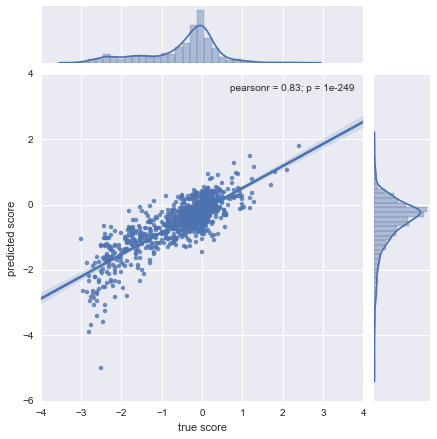

In [87]:
data_blocked = get_labeled_comments(d_blocked, reg_labels_blocked['aggression'])
train, test = split(data_blocked)
model = tune (train['x'], train['y'], reg_pipeline, param_grid, 'mean_squared_error', n_jobs=8, verbose=True)
_ = evaluate(model, test, plot = True)

#### Random Data Set


Best parameters set found:
{'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.1, 'vect__max_features': None} -0.0957710006683


Grid scores:
-0.09790 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__alpha': 0.01, 'vect__max_features': None}
-0.09654 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.01, 'vect__max_features': None}
-0.09764 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__alpha': 0.1, 'vect__max_features': None}
-0.09577 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.1, 'vect__max_features': None}
-0.10137 (+/-0.00000) for {'vect__ngram_range': (1, 6), 'vect__analyzer': 'char', 'clf__alpha': 0.5, 'vect__max_features': None}
-0.09898 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'clf__alpha': 0.5, 'vect__max_features': None}


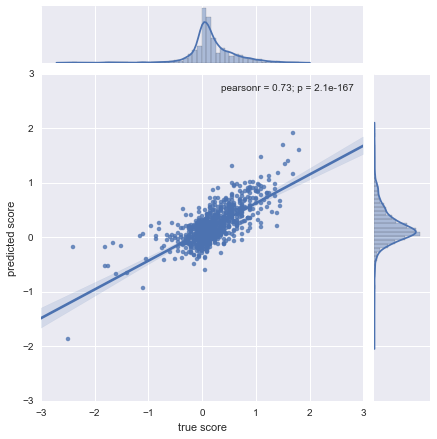

In [88]:
data_random = get_labeled_comments(d_random, reg_labels_random['aggression'])
train, test = split(data_random)
model = tune (train['x'], train['y'], reg_pipeline, param_grid, 'mean_squared_error', n_jobs=8, verbose=True)
_ = evaluate(model, test, plot = True)

In [52]:
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,6))),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', Ridge(alpha = 0.01)),
])

### Finding the Optimal Blend

Keep size of trainind data fixed. Vary proportion of blocked and random data in training. Eval the blend on held out data from blocked and random.

In [42]:
def eval_blended_training(pipeline, blocked, random, test_size = 0.2):
    
    blocked_train, blocked_test = split(blocked, test_size = test_size)
    random_train, random_test = split(random, test_size = test_size)
    
    
    m = min(blocked_train.shape[0], random_train.shape[0])
    
   
    
    blocked_metric = []
    random_metric = []
    alphas = np.arange(0,1.01, 0.2)
    
    for alpha in alphas:
        train = pd.concat([blocked_train[:int(alpha*m)], random_train[:int((1-alpha)*m)]])        
        model = pipeline.fit(train['x'].values, train['y'].values)
        blocked_metric.append(evaluate(model, blocked_test))
        random_metric.append(evaluate(model, random_test))
        
    return  alphas,  blocked_metric, random_metric

In [43]:
a, b, r = eval_blended_training(pipeline, data_blocked, data_random, test_fraction = 0.2)

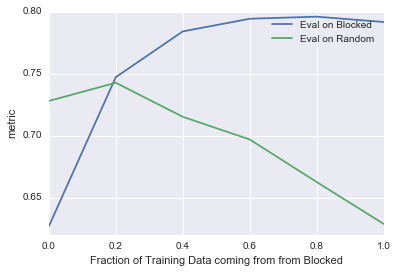

In [44]:
plt.plot(a, b, label = 'Eval on Blocked')
plt.plot(a, r, label = 'Eval on Random')
plt.legend()
plt.xlabel('Fraction of Training Data coming from from Blocked')
plt.ylabel('metric')

### Does adding random data improve prediction on blocked data?

Incrementally add random data to full blocked data set on training. Eval on held out blocked data.

In [79]:
def eval_adding_other_data(pipeline, a, b, test_size = 0.2):
    train, test = split(a, test_size = test_size)
    
    k = 10
    step = int((b.shape[0]) / float(k))
    ms = range(0, b.shape[0], step)
    metrics = []    
    for m in ms:
        train = pd.concat([train, b[:m]])
        model = pipeline.fit(train['x'].values, train['y'].values)
        metrics.append(evaluate(model, test))
    
    return ms, metrics  

In [80]:
ms, metrics = eval_adding_other_data(pipeline, data_blocked, data_random, test_size = 0.2)

range(0, 4998, 499)


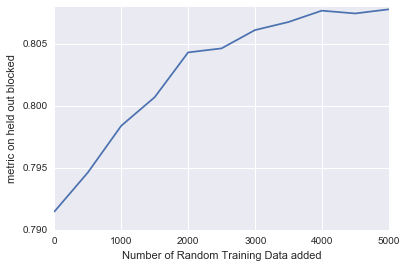

In [81]:
plt.plot(ms, metrics)
plt.legend()
plt.xlabel('Number of Random Training Data added')
plt.ylabel('metric on held out blocked data')

### Does adding blocked data improve prediction on random data?

Incrementally add blocked data to full random data set on training. Eval on held out random data.

In [84]:
ms, metrics = eval_adding_other_data(pipeline, data_random, data_blocked, test_size = 0.2)

range(0, 4997, 499)


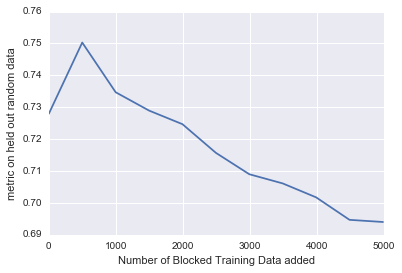

In [85]:
plt.plot(ms, metrics)
plt.legend()
plt.xlabel('Number of Blocked Training Data added')
plt.ylabel('metric on held out random data')

### Scratch

In [45]:
#joblib.dump(aggression_model, '../models/aggression_ngram.pkl')

In [47]:
#attack_model = regress(comments, reg_labels['attack'], param_grid, reg_pipeline)
#joblib.dump(attack_model, '../models/aggression_ngram.pkl')

In [ ]:
#recipient_model = regress(comments, reg_labels['recipient'], param_grid, reg_pipeline)
#joblib.dump(recipient_model, '../models/recipient_ngram.pkl')

In [ ]:
# classification
# error analysis
# learning curves

In [ ]:
#inspect.sort_values(by = 'pred_score', inplace = True)
#for i in range(10):
    #print(inspect.iloc[i]['score'], inspect.iloc[i]['pred_score'], inspect.iloc[i]['x'], '\n')